<a href="https://colab.research.google.com/github/suruchi1997/yolov7/blob/main/tl_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

68606236/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [4]:
# Dividing into val and test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
     

Number of validation batches: 26
Number of test batches: 6


In [5]:
#Load data directly from disk
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

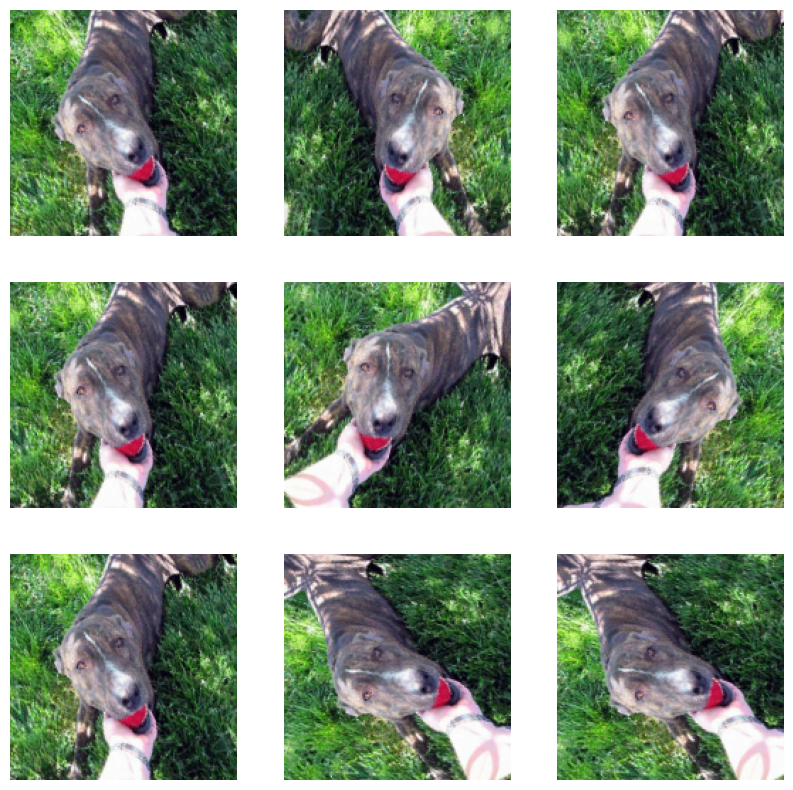

In [6]:
# data augmentation , since dataset is small
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
     


In [7]:
# Rescaling the data according to the model we are utilizing 
preprocess_input = tf.keras.applications.vgg16.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [8]:
# Using VGG for  feature extraction , include_top=false will not include dense layers for classification
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

     

58889256/58889256 [==============================] - 0s 0us/step


In [9]:

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# feeze convolution layers of base model
base_model.trainable = False

# summarizing base_model
base_model.summary()


(32, 5, 5, 512)
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 1

In [11]:
#clasification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

#using training = False as model has batchnormalization layer
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
     

(32, 512)
(32, 1)


In [12]:
#compile model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()
     

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0   

In [13]:

# trainable variables
len(model.trainable_variables)

#evaluation after 10 epochs
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 [==============================] - 6s 99ms/step - loss: 1.8545 - accuracy: 0.6894
initial loss: 1.85
initial accuracy: 0.69


In [14]:

# fitting train_dataset
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 10s 129ms/step - loss: 2.0586 - accuracy: 0.6330 - val_loss: 1.2831 - val_accuracy: 0.7550
Epoch 2/10
63/63 [==============================] - 7s 103ms/step - loss: 1.7893 - accuracy: 0.6570 - val_loss: 1.0353 - val_accuracy: 0.7859
Epoch 3/10
63/63 [==============================] - 7s 106ms/step - loss: 1.4588 - accuracy: 0.7065 - val_loss: 0.8608 - val_accuracy: 0.8144
Epoch 4/10
63/63 [==============================] - 7s 104ms/step - loss: 1.3929 - accuracy: 0.7175 - val_loss: 0.6933 - val_accuracy: 0.8428
Epoch 5/10
63/63 [==============================] - 7s 105ms/step - loss: 1.1295 - accuracy: 0.7430 - val_loss: 0.5788 - val_accuracy: 0.8626
Epoch 6/10
63/63 [==============================] - 7s 106ms/step - loss: 1.1507 - accuracy: 0.7500 - val_loss: 0.5542 - val_accuracy: 0.8688
Epoch 7/10
63/63 [==============================] - 7s 107ms/step - loss: 1.0029 - accuracy: 0.7715 - val_loss: 0.4497 - val_accuracy: 0.8899
Epoch

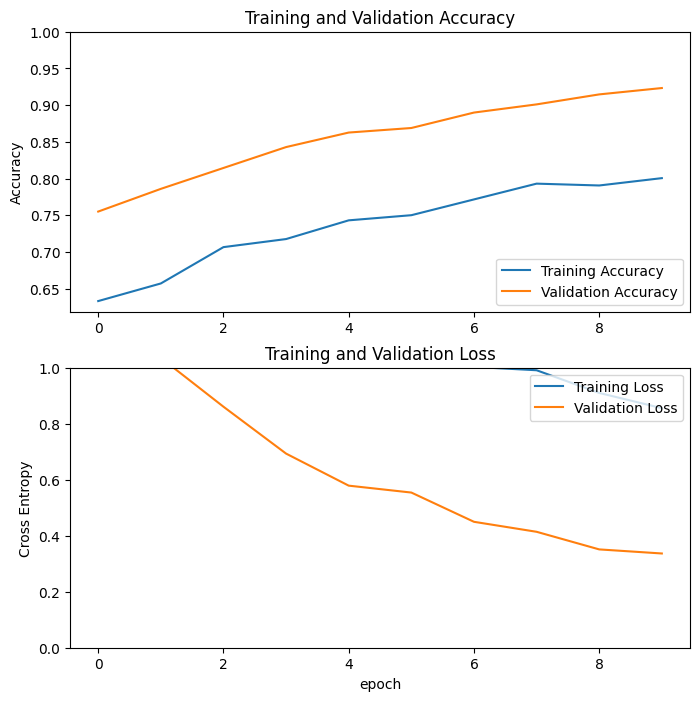

In [15]:

#learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
#fine tune
#unfreeze top layers
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
# model summary
model.summary()

Number of layers in the base model:  19
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_poo

Epoch 10/30
63/63 [==============================] - 10s 111ms/step - loss: 0.8814 - accuracy: 0.8005 - val_loss: 0.3080 - val_accuracy: 0.9257
Epoch 11/30
63/63 [==============================] - 7s 107ms/step - loss: 0.7381 - accuracy: 0.8285 - val_loss: 0.3248 - val_accuracy: 0.9233
Epoch 12/30
63/63 [==============================] - 7s 109ms/step - loss: 0.8008 - accuracy: 0.8200 - val_loss: 0.3101 - val_accuracy: 0.9282
Epoch 13/30
63/63 [==============================] - 7s 111ms/step - loss: 0.7758 - accuracy: 0.8180 - val_loss: 0.3148 - val_accuracy: 0.9245
Epoch 14/30
63/63 [==============================] - 7s 115ms/step - loss: 0.8310 - accuracy: 0.8135 - val_loss: 0.3120 - val_accuracy: 0.9282
Epoch 15/30
63/63 [==============================] - 7s 109ms/step - loss: 0.7620 - accuracy: 0.8255 - val_loss: 0.2974 - val_accuracy: 0.9307
Epoch 16/30
63/63 [==============================] - 8s 118ms/step - loss: 0.7269 - accuracy: 0.8260 - val_loss: 0.3026 - val_accuracy: 0.931

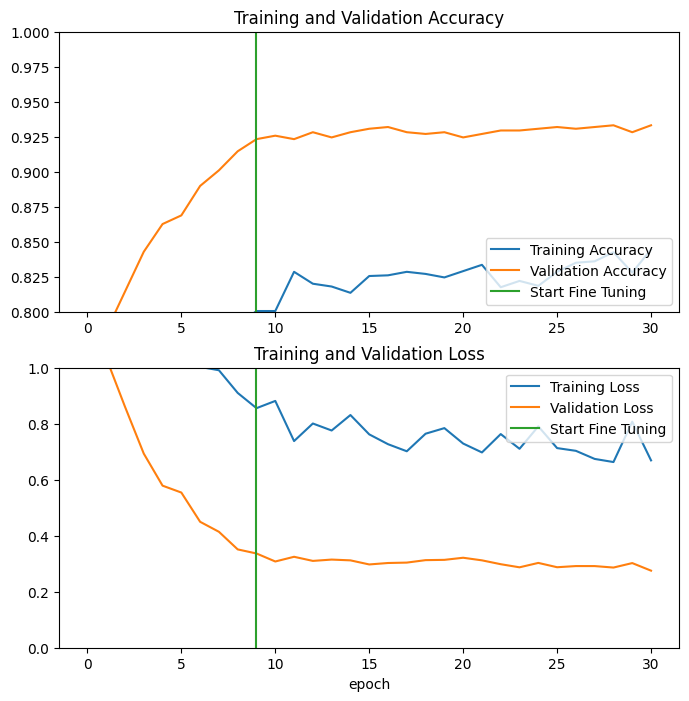

In [17]:

len(model.trainable_variables)

# continue training the model

fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

# compute loss
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
# plot the curves

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()